* **This kernel is based on one of the exercises in the excellent book: Deep Learning with Python by Francois Chollet**
* It is a single-label (mutually exclusive), multi class classification of text problem 
* Solved using Keras - the Deep Learning framework I much appreciate (with TensorFlow as its backend)
* The kernel imports the Reuters dataset from Keras

In [1]:
import os
from operator import itemgetter    
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
#from sklearn.utils.fixes import signature
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
 
from keras.datasets import reuters

print(os.getcwd())
print("Modules imported \n")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Using TensorFlow backend.


/kaggle/working
Modules imported 



In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 1s 1us/step


In [3]:
print("train_data ", train_data.shape)
print("train_labels ", train_labels.shape)

print("test_data ", test_data.shape)
print("test_labels ", test_labels.shape)

train_data  (8982,)
train_labels  (8982,)
test_data  (2246,)
test_labels  (2246,)


In [4]:
# Reverse dictionary to see words instead of integers
# Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])

print(decoded_newswire)
print(train_labels[0])

557056/550378 [==============================] - 1s 2us/step
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
3


In [5]:
# VECTORIZE function

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [6]:
# Vectorize and Normalize train and test to tensors with 10k columns

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (8982, 10000)
x_test  (2246, 10000)


In [7]:
# ONE HOT ENCODER of the labels

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print("one_hot_train_labels ", one_hot_train_labels.shape)
print("one_hot_test_labels ", one_hot_test_labels.shape)

one_hot_train_labels  (8982, 46)
one_hot_test_labels  (2246, 46)


In [8]:
# Setting aside a VALIDATION set

x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

print("x_val ", x_val.shape)
print("y_val ", y_val.shape)

print("partial_x_train ", partial_x_train.shape)
print("partial_y_train ", partial_y_train.shape)

x_val  (1000, 10000)
y_val  (1000, 46)
partial_x_train  (7982, 10000)
partial_y_train  (7982, 46)


In [9]:
# MODEL

model = models.Sequential()
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))
model.summary()
# REGULARIZERS L1 L2
#regularizers.l1(0.001)
#regularizers.l2(0.001)
#regularizers.l1_l2(l1=0.001, l2=0.001)

# Best results I got with HU=128/128/128 or 256/256 and L1=0.001 and Dropout=0.5 = 77.02%
# Without Regularizer 72.92%
# Reg L1 = 76.04, L2 = 76.2, L1_L2 = 76.0
# Only DropOut (0.5) = 76.85%

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 46)                11822     
Total params: 2,637,870
Trainable params: 2,637,870
Non-trainable params: 0
_________________________________________________________________


In [10]:
# FIT / TRAIN model

NumEpochs = 10
BatchSize = 512

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val))

results = model.evaluate(x_val, y_val)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)

history_dict = history.history
history_dict.keys()

Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 3s 370us/step - loss: 15.6790 - acc: 0.4597 - val_loss: 6.1709 - val_acc: 0.5650
Epoch 2/10
7982/7982 [==============================] - 2s 283us/step - loss: 5.7369 - acc: 0.5599 - val_loss: 5.1676 - val_acc: 0.6570
Epoch 3/10
7982/7982 [==============================] - 2s 282us/step - loss: 4.9509 - acc: 0.6065 - val_loss: 4.5964 - val_acc: 0.6120
Epoch 4/10
7982/7982 [==============================] - 2s 284us/step - loss: 4.4353 - acc: 0.6227 - val_loss: 4.1167 - val_acc: 0.6710
Epoch 5/10
7982/7982 [==============================] - 2s 282us/step - loss: 4.0100 - acc: 0.6465 - val_loss: 3.7863 - val_acc: 0.6610
Epoch 6/10
7982/7982 [==============================] - 2s 281us/step - loss: 3.7231 - acc: 0.6515 - val_loss: 3.5165 - val_acc: 0.6700
Epoch 7/10
7982/7982 [==============================] - 2s 283us/step - loss: 3.5175 - acc: 0.6626 - val_loss: 3.3814 - val_acc: 0.6900

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

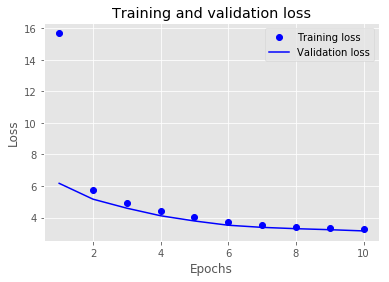

In [11]:
# VALIDATION LOSS curves

plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

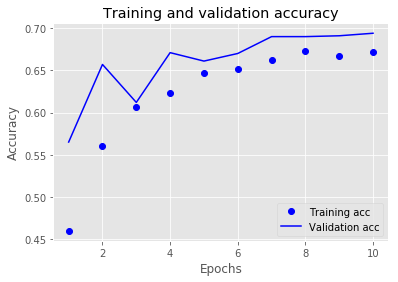

In [12]:
## VALIDATION ACCURACY curves

plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Retrain from scratch for # of epochs per LEARNING curves above - and evaluate with TEST (which was set aside above)

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(partial_x_train,partial_y_train,epochs= 20, batch_size=512,
validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

print("_"*100)
print(results)

In [13]:
# PREDICT

predictions = model.predict(x_test)
# Each entry in predictions is a vector of length 46
print(predictions[123].shape)

# The coefficients in this vector sum to 1:
print(np.sum(predictions[123]))

# The largest entry is the predicted class — the class with the highest probability:
print(np.argmax(predictions[123]))

(46,)
0.9999999
4


In [14]:
# Get the top 3 classes
predictions[21].argsort()[-3:][::-1]

array([ 3, 16,  4])

In [15]:
test_labels[21]

3

In [16]:
SampleNum = 2125

print(test_labels[SampleNum])
print(predictions[SampleNum].argsort()[-3:][::-1])

test_labels[SampleNum] in predictions[SampleNum].argsort()[-3:][::-1]

6
[ 4  3 19]


False

In [17]:
# Create a top 3 matrix

Top3Preds = np.zeros((2246,3), dtype=int)
print(Top3Preds.shape)

for SampleNum in range(predictions.shape[0]):
    Top3Preds[SampleNum] = predictions[SampleNum].argsort()[-3:][::-1]
    
Top3Preds

(2246, 3)


array([[ 3,  4, 16],
       [ 1, 11, 16],
       [ 1, 16, 11],
       ...,
       [ 3,  4,  8],
       [ 3,  4, 16],
       [ 1, 11, 16]])

In [18]:
# Modify the raw final_predictions - prediction probs into 0 and 1 for the confusion matrix

FinalPreds = np.zeros((2246,1), dtype=int)
print(FinalPreds.shape)

for SampleNum in range(Top3Preds.shape[0]):
    if test_labels[SampleNum] in Top3Preds[SampleNum]:
        FinalPreds[SampleNum] = 1
        
FinalPreds

(2246, 1)


array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [19]:
FinalPreds = pd.DataFrame(FinalPreds)
NumTop3 = FinalPreds[0][FinalPreds[0] == 1].count()
percentTop3 = round(100 *NumTop3 / FinalPreds.shape[0], 1)

print('Percent of one from top 3 being correct ... ', percentTop3, '%')


Percent of one from top 3 being correct ...  76.4 %
